# 优化版本 - Titanic Random Forest 模型

整合了多个优化策略：
1. 高级特征工程
2. 特征选择
3. 处理不平衡数据
4. 集成学习
5. 交叉验证优化

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

# 设置随机种子
np.random.seed(42)

In [4]:
def create_advanced_features(df):
    # 创建新特征的副本
    data = df.copy()
    
    # 1. 票价分箱
    data['Fare_Bin'] = pd.qcut(data['Fare'], q=4, labels=['Low', 'Medium', 'High', 'Very High'])
    
    # 2. 年龄分组
    data['Age_Group'] = pd.cut(data['Age'], 
                          bins=[0, 12, 18, 35, 50, 100],
                          labels=['Child', 'Teenager', 'Young Adult', 'Adult', 'Elder'])
    
    # 3. 家庭规模分类
    data['Family_Category'] = pd.cut(data['FamilySize'],
                                bins=[0, 1, 4, 20],
                                labels=['Single', 'Small', 'Large'])
    
    # 4. 创建交互特征
    data['Age_Class'] = data['Age'] * data['Pclass']
    data['Fare_Per_Person'] = data['Fare'] / data['FamilySize']
    
    # 5. 对数变换
    data['Log_Fare'] = np.log1p(data['Fare'])
    
    # 只对新的分类变量进行独热编码
    data = pd.get_dummies(data, columns=['Fare_Bin', 'Age_Group', 'Family_Category'])
    
    return data
def handle_outliers(df, columns):
    df = df.copy()
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        df[col] = df[col].clip(lower=Q1-1.5*IQR, upper=Q3+1.5*IQR)
    return df

In [5]:
# 加载数据
train_data = pd.read_csv('data/processed_train.csv')
test_data = pd.read_csv('data/processed_test.csv')

# 处理异常值
numerical_cols = ['Age', 'Fare']
train_data = handle_outliers(train_data, numerical_cols)
test_data = handle_outliers(test_data, numerical_cols)

# 创建高级特征
train_data = create_advanced_features(train_data)
test_data = create_advanced_features(test_data)

# 准备特征和目标变量
feature_cols = [col for col in train_data.columns if col not in ['Survived', 'Name', 'Ticket', 'Cabin']]
X = train_data[feature_cols]
y = train_data['Survived']
X_test = test_data[feature_cols]

# 划分训练集和验证集
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print("训练集形状:", X_train.shape)
print("验证集形状:", X_val.shape)

训练集形状: (712, 32)
验证集形状: (179, 32)


In [6]:
# 创建优化的随机森林模型
param_grid = {
    'n_estimators': [200, 300, 400],
    'max_depth': [10, 15, 20, None],
    'min_samples_split': [2, 5, 8],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'class_weight': ['balanced', 'balanced_subsample']
}

# 创建SMOTE和随机森林的管道
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(random_state=42))
])

# 网格搜索
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid={'rf__' + key: val for key, val in param_grid.items()},
    cv=5,
    n_jobs=-1,
    verbose=2,
    scoring='roc_auc'
)

# 训练模型
grid_search.fit(X_train, y_train)

print("最佳参数:", grid_search.best_params_)
print("最佳交叉验证得分:", grid_search.best_score_)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
最佳参数: {'rf__class_weight': 'balanced_subsample', 'rf__max_depth': 10, 'rf__max_features': 'sqrt', 'rf__min_samples_leaf': 4, 'rf__min_samples_split': 2, 'rf__n_estimators': 200}
最佳交叉验证得分: 0.8568670326328796


In [7]:
# 使用最佳模型进行预测
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_val)
y_pred_proba = best_model.predict_proba(X_val)[:, 1]

# 评估模型
print("\n分类报告:")
print(classification_report(y_val, y_pred))
print(f"\nROC-AUC分数: {roc_auc_score(y_val, y_pred_proba):.4f}")


分类报告:
              precision    recall  f1-score   support

           0       0.87      0.86      0.86       105
           1       0.80      0.81      0.81        74

    accuracy                           0.84       179
   macro avg       0.83      0.83      0.83       179
weighted avg       0.84      0.84      0.84       179


ROC-AUC分数: 0.9051


C:\Users\Administrator\AppData\Local\Temp\ipykernel_31828\1706776969.py:13: UserWarning: Glyph 26368 (\N{CJK UNIFIED IDEOGRAPH-6700}) missing from current font.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_31828\1706776969.py:13: UserWarning: Glyph 37325 (\N{CJK UNIFIED IDEOGRAPH-91CD}) missing from current font.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_31828\1706776969.py:13: UserWarning: Glyph 35201 (\N{CJK UNIFIED IDEOGRAPH-8981}) missing from current font.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_31828\1706776969.py:13: UserWarning: Glyph 29305 (\N{CJK UNIFIED IDEOGRAPH-7279}) missing from current font.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Temp\ipykernel_31828\1706776969.py:13: UserWarning: Glyph 24449 (\N{CJK UNIFIED IDEOGRAPH-5F81}) missing from current font.
  plt.tight_layout()
C:\Users\Administrator\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2k

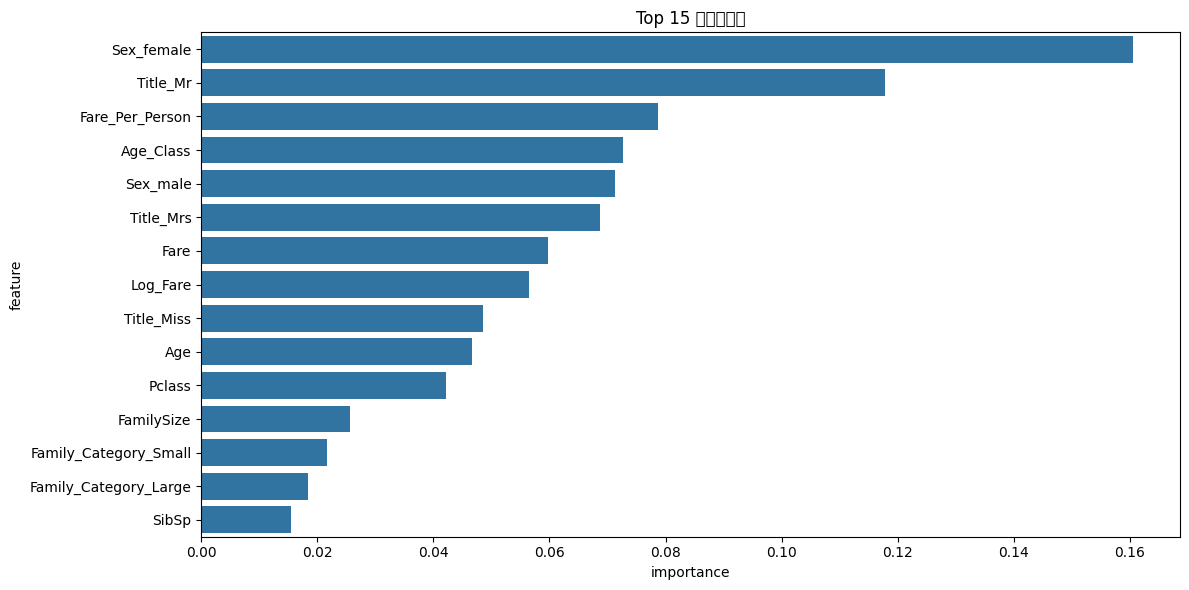

In [8]:
# 分析特征重要性
rf_model = best_model.named_steps['rf']
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

# 绘制特征重要性图
plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance.head(15), x='importance', y='feature')
plt.title('Top 15 最重要特征')
plt.tight_layout()
plt.show()

In [9]:
# 生成最终预测
final_predictions = best_model.predict(X_test)

# 创建提交文件
submission = pd.DataFrame({
    'PassengerId': range(892, 892 + len(final_predictions)),
    'Survived': final_predictions
})

# 保存预测结果
submission.to_csv('data/optimized_rf_submission.csv', index=False)
print("预测结果已保存到 'optimized_rf_submission.csv'")

预测结果已保存到 'optimized_rf_submission.csv'
